In [45]:
import cv2
import matplotlib.pyplot as plt

In [46]:
# Load the input image
image = cv2.imread('baby.jpg')
image = cv2.resize(image, (720, 640))

In [47]:
# Paths to model files
face1 = "opencv_face_detector.pbtxt"
face2 = "opencv_face_detector_uint8.pb"
age1 = "age_deploy.prototxt"
age2 = "age_net.caffemodel"
gen1 = "gender_deploy.prototxt"
gen2 = "gender_net.caffemodel"

In [48]:
# Mean values for model
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

# Load models
face = cv2.dnn.readNet(face2, face1)
age = cv2.dnn.readNet(age2, age1)
gen = cv2.dnn.readNet(gen2, gen1)

In [49]:
# Categories for age and gender
age_labels = ['(0-2)', '(4-6)', '(8-12)', '(15-20)',
              '(25-32)', '(38-43)', '(48-53)', '(60-100)']
gender_labels = ['Male', 'Female']

# Copy image
fr_cv = image.copy()

In [50]:
# Face detection
fr_h, fr_w = fr_cv.shape[:2]
blob = cv2.dnn.blobFromImage(fr_cv, 1.0, (300, 300), MODEL_MEAN_VALUES, swapRB=True, crop=False)

face.setInput(blob)
detections = face.forward()

In [51]:
# Face bounding box creation
faceBoxes = []
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.7:
        x1 = int(detections[0, 0, i, 3] * fr_w)
        y1 = int(detections[0, 0, i, 4] * fr_h)
        x2 = int(detections[0, 0, i, 5] * fr_w)
        y2 = int(detections[0, 0, i, 6] * fr_h)
        faceBoxes.append([x1, y1, x2, y2])
        cv2.rectangle(fr_cv, (x1, y1), (x2, y2), (0, 255, 0), int(round(fr_h / 150)), 8)

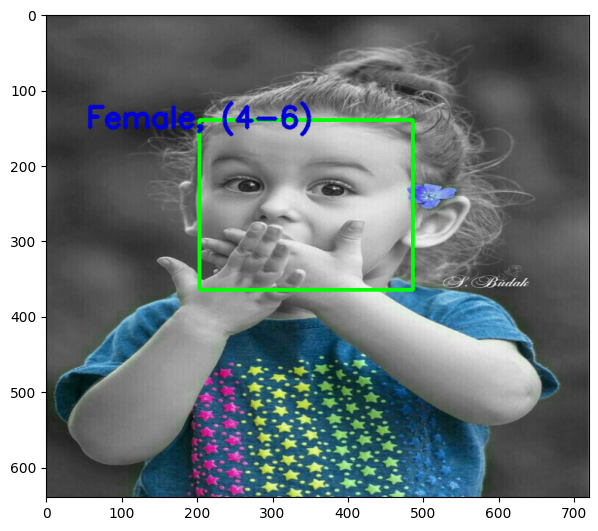

In [52]:
# Checking if face detected or not
if not faceBoxes:
    print("No face detected")
else:
    # Loop for all the faces detected
    for faceBox in faceBoxes:
        # Extracting face as per the faceBox
        face = fr_cv[max(0, faceBox[1] - 15):min(faceBox[3] + 15, fr_h - 1),
                     max(0, faceBox[0] - 15):min(faceBox[2] + 15, fr_w - 1)]

        # Extracting the main blob part
        blob = cv2.dnn.blobFromImage(
            face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        # Prediction of gender
        gen.setInput(blob)
        genderPreds = gen.forward()
        gender = gender_labels[genderPreds[0].argmax()]

        # Prediction of age
        age.setInput(blob)
        agePreds = age.forward()
        age_pred = agePreds[0].argmax()
        age = age_labels[age_pred]

        # Putting text of age and gender at the top of the box
        cv2.putText(fr_cv,
                    f'{gender}, {age}',
                    (faceBox[0] - 150, faceBox[1] + 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.3,
                    (217, 0, 0),
                    4,
                    cv2.LINE_AA)

    # Display the image with detections
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(fr_cv, cv2.COLOR_BGR2RGB))
    plt.show()
